In [1]:
import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
def read_parquet_data(filepath: str, preprocess: bool = False) -> pd.DataFrame:
    if not os.path.exists(filepath):
        print("No such file exists!")
        return
        
    try:
        df = pd.read_parquet(filepath)
    except Exception:
        print("Provide correct .parquet data!")
        return
    
    df["duration"] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    if preprocess:
        # filter out trips that took less than one minute and more than one hour
        df = df[(df.duration >= 1) & (df.duration <= 60)]
         
        # replace missing pickup and drop off location ids with -1
        df.PUlocationID = df.PUlocationID.fillna(-1)
        df.DOlocationID = df.DOlocationID.fillna(-1)
        
        # convert categorical features to strings
        categorical = ["PUlocationID", "DOlocationID"]
        df[categorical] = df[categorical].astype(str)
        
    return df    

In [3]:
# load train and validaton data
train_df = read_parquet_data("../mlops-zoomcamp/data/fhv_tripdata_2021-01.parquet")
val_df = read_parquet_data("../mlops-zoomcamp/data/fhv_tripdata_2021-02.parquet")

print(f"Number of rows in training data: {train_df.shape[0]}")
print(f"Number of rows in validation data: {val_df.shape[0]}")

Number of rows in training data: 1154112
Number of rows in validation data: 1037692


In [4]:
# find average trip duration
print(f"Average duration in training data: {train_df.duration.mean()}")
print(f"Average duration in validation data: {val_df.duration.mean()}")

Average duration in training data: 19.167224093791006
Average duration in validation data: 20.706986225199763


/mnt/c/Users/Sokol/Desktop/mlops-zoomcamp/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/c/Users/Sokol/Desktop/mlops-zoomcamp/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


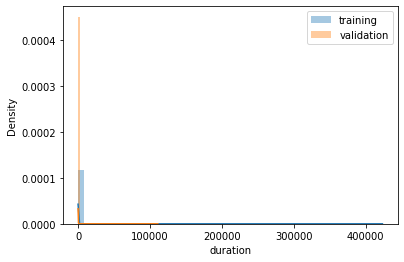

In [5]:
# show duration distribution 
sns.distplot(train_df.duration, label='training')
sns.distplot(val_df.duration, label='validation')
plt.legend()

Number of rows in training data: 1109826
Number of rows in validation data: 990113


/mnt/c/Users/Sokol/Desktop/mlops-zoomcamp/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/c/Users/Sokol/Desktop/mlops-zoomcamp/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


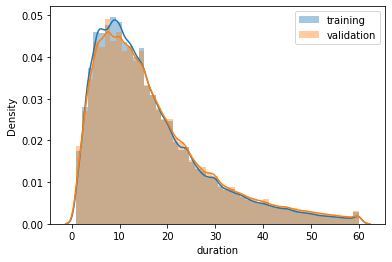

In [6]:
# read preprocessed data (with duration validation) and check distributions once again
train_df = read_parquet_data("../mlops-zoomcamp/data/fhv_tripdata_2021-01.parquet", preprocess=True)
val_df = read_parquet_data("../mlops-zoomcamp/data/fhv_tripdata_2021-02.parquet", preprocess=True)

print(f"Number of rows in training data: {train_df.shape[0]}")
print(f"Number of rows in validation data: {val_df.shape[0]}")

sns.distplot(train_df.duration, label='training')
sns.distplot(val_df.duration, label='validation')
plt.legend()

In [7]:
# find fraction of missing pickup values
print(f"Fractions of values in pickup location ids of training data:\n {train_df.PUlocationID.value_counts(normalize=True)}")
print(f"\n\nFractions of values in drop off location ids of training data:\n {train_df.DOlocationID.value_counts(normalize=True)}")

Fractions of values in pickup location ids of training data:
 -1.0     8.352733e-01
221.0    7.505681e-03
206.0    6.124383e-03
129.0    4.846706e-03
115.0    3.678054e-03
             ...     
111.0    4.505211e-06
27.0     3.604169e-06
34.0     2.703126e-06
2.0      1.802084e-06
110.0    9.010421e-07
Name: PUlocationID, Length: 262, dtype: float64


Fractions of values in drop off location ids of training data:
 -1.0     1.332704e-01
76.0     2.376499e-02
217.0    1.755951e-02
265.0    1.678461e-02
17.0     1.659900e-02
             ...     
27.0     1.621876e-05
30.0     1.171355e-05
2.0      9.911464e-06
105.0    3.604169e-06
199.0    9.010421e-07
Name: DOlocationID, Length: 263, dtype: float64


In [8]:
# apply one hot encoding to categorical features
categorical = ["PUlocationID", "DOlocationID"]

train_dicts = train_df[categorical].to_dict(orient="records")
val_dicts = val_df[categorical].to_dict(orient="records")
dv = DictVectorizer()

x_train = dv.fit_transform(train_dicts)
x_val = dv.transform(val_dicts)

print(x_train.shape)
print(x_val.shape)

(1109826, 525)
(990113, 525)


In [9]:
# train the linear model
y_train = train_df.duration.values
y_val = val_df.duration.values

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [10]:
# get the predictions and calculate mean squared error
y_pred_train = model.predict(x_train)
y_pred_val = model.predict(x_val)

rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)

print(f"RMSE on training data: {rmse_train}")
print(f"RMSE on validation data: {rmse_val}")

RMSE on training data: 10.52851938944385
RMSE on validation data: 11.014286426107942


In [11]:
with open("../models/lin_reg_homework01.bin", "wb") as f_out:
    pickle.dump((dv, model), f_out)